In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skradar

# Radar Settings
Here we define some important settings like bandwidth, number of fast- and slow-time samples etc. We assume a continuous-wave radar without any gaps. Therefore, the slow-time sampling rate can be derived from the fast-time settings.

In [10]:
B = 1e9
fc = 76.5e9
N_f = 512  # number of fast-time samples
fs_f = 1e6  # fast-time sampling rate
Ts_s = (N_f-1)/fs_f  # slow-time sampling interval
N_s = 1  # number of slow-time samples

Next we define the positions of transmit (TX) and receive (RX) antennas in the local coordinate system of the radar. In this example both TX and RX are placed at the local origin.

In [11]:
tx_pos = np.array([[0], [0], [0]])
rx_pos = np.array([[0], [0], [0]])

Now we can place a virtual radar at the origin of the world coordinate system

In [12]:
radar_pos = np.array([[0], [0], [0]])
L_freqs_vec = np.array([10, 100e3, 300e3, 5000e3, 1e8])
L_dB_vec = np.array([-65, -65, -85, -115, -115])
radar = skradar.FMCWRadar(B=B, fc=fc, N_f=N_f, T_f=1/fs_f, T_s=Ts_s,L_freqs_vec=L_freqs_vec,L_dB_vec=L_dB_vec,
                          N_s=N_s, tx_pos=tx_pos, rx_pos=rx_pos, tx_ant_gains = np.array([15]),
                          rx_ant_gains = np.array([10]), pos=radar_pos, name='First radar')

TypeError: Thing.__init__() got an unexpected keyword argument 'L_freqs_vec'

# Target Placement, Scene Configuration, and Visualization
Place a target at a distance of 11.3 m in y-direction

In [ ]:
target_pos = np.array([[0], [11.3], [0]])
target = skradar.Target(rcs=10, pos=target_pos, name='Static target, 10 sqm')

Configure the scene which consists of radar and target and visualize it. The visualization is plotted in the world coordinate system, therefore radar and world coordinates overlap.

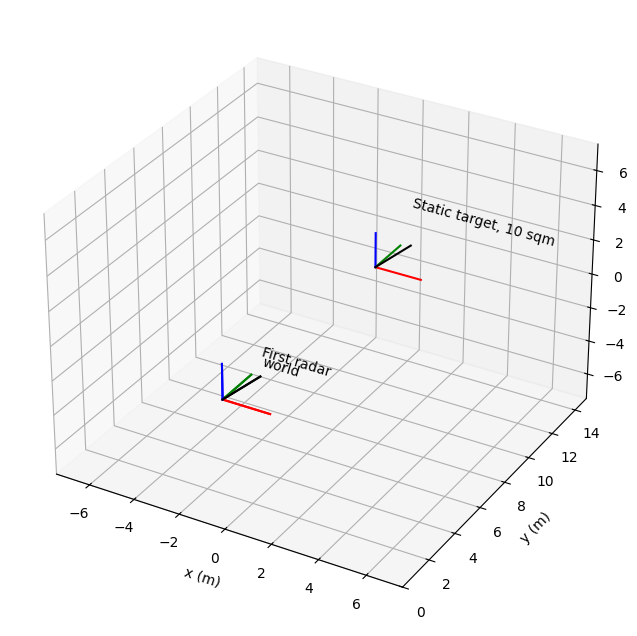

In [ ]:
scene = skradar.Scene([radar], [target])

fig = plt.figure(1, figsize=(12, 8))
plt.clf()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim((-7.5, 7.5))
ax.set_ylim((0, 15))
ax.set_zlim((-7.5, 7.5))
scene.visualize('world', ax, coord_len=2)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')

Note that it would also be possible to visualize the scene in other coordinate systems. The following plot shows the scene in the coordinate system of the target.

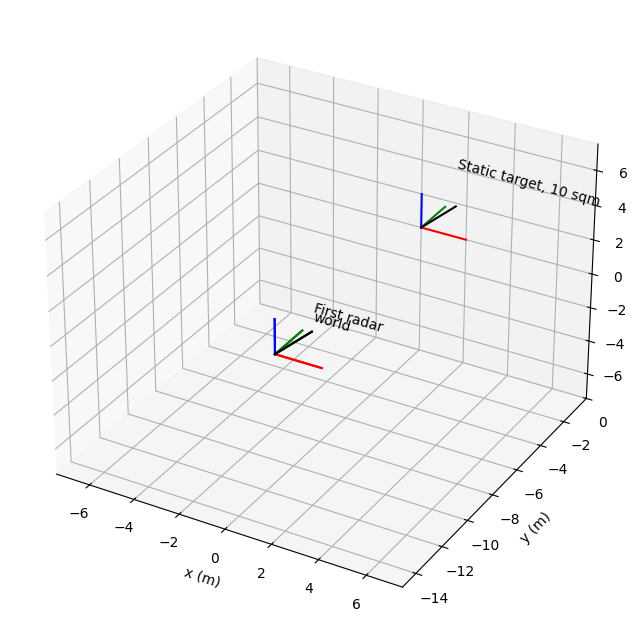

In [ ]:
fig = plt.figure(2, figsize=(12, 8))
plt.clf()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim((-7.5, 7.5))
ax.set_ylim((-15, 0))
ax.set_zlim((-7.5, 7.5))
scene.visualize(target, ax, coord_len=2)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')

# Radar Signal Simulation and Range Processing
The function ```sim_chirps``` automatically calculates all distances between the targets in the scene and all TX- and RX-antennas. Here ```radar``` is an ```FMCWRadar``` object; therefore the results are the dechirped signals for each TX-RX combination.

In [ ]:
radar.sim_chirps()

Now it is possible to perform range compression on the FMCW IF signal which is realized within the ```range_compression``` function.

In [ ]:
radar.range_compression(zp_fact=32)

The range profile should show a maximum at the target distance. Real-valued signals lead to a symmetric spectrum, therefore here only half of the range profile is relevant. The values of ```radar.ranges``` describe round-trip ranges. To plot target distances, these values therefore need to be halved (this holds for monostatic radars with TX and RX at the same position).

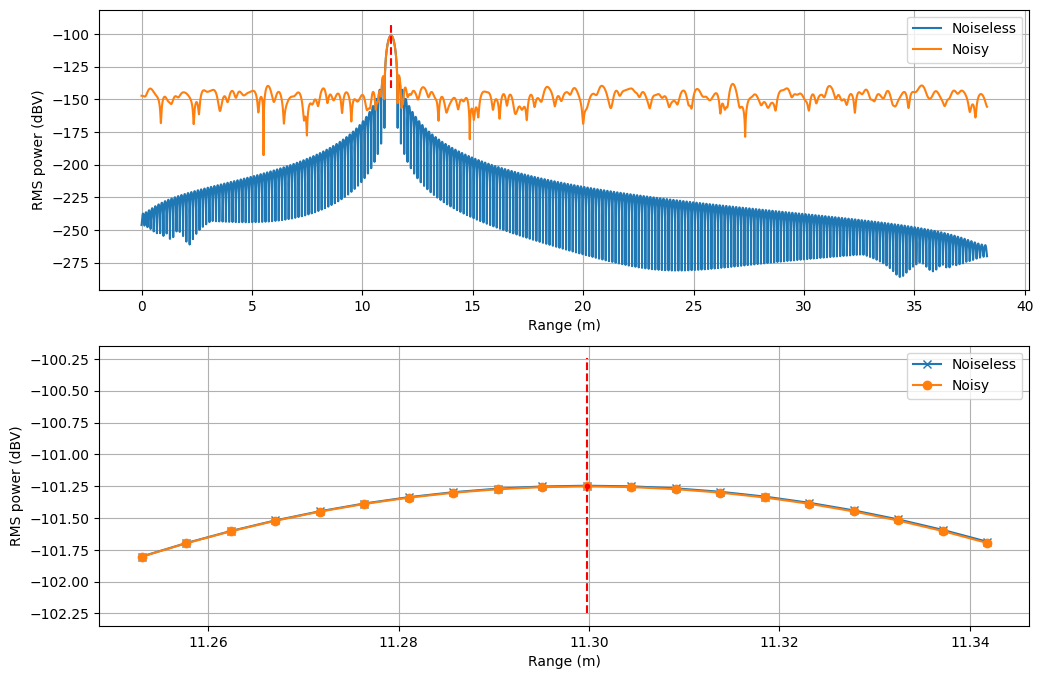

In [ ]:
target_dists = radar.ranges/2  # halve values to account for round-trip ranges
target_dists_plot = target_dists[:len(radar.ranges)//2]
# sqrt(2) to convert to RMS power from sinusoidal peak value
rp_plot = 1/(np.sqrt(2))*radar.rp[0, 0, 0, :len(radar.ranges)//2]
rp_plot_noisy = 1/(np.sqrt(2))*radar.rp_noisy[0, 0, 0, :len(radar.ranges)//2]
peak_idx = np.argmax(np.abs(rp_plot))

plt.figure(2, figsize=(12, 8))
plt.clf()
plt.subplot(2, 1, 1)
plt.plot(target_dists_plot, 20*np.log10(np.abs(rp_plot)), label='Noiseless')
plt.plot(target_dists_plot, 20*np.log10(np.abs(rp_plot_noisy)), label='Noisy')
plt.plot([target_dists_plot[peak_idx], target_dists_plot[peak_idx]], [
         20*np.log10(np.abs(rp_plot[peak_idx]))-40, 20*np.log10(np.abs(rp_plot[peak_idx]))+10], '--r')
plt.legend()
plt.grid(True)
plt.xlabel('Range (m)')
plt.ylabel('RMS power (dBV)')
plt.subplot(2, 1, 2)
plt.plot(target_dists_plot[peak_idx-10:peak_idx+10], 20 *
         np.log10(np.abs(rp_plot[peak_idx-10:peak_idx+10])), '-x', label='Noiseless')
plt.plot(target_dists_plot[peak_idx-10:peak_idx+10], 20 *
         np.log10(np.abs(rp_plot_noisy[peak_idx-10:peak_idx+10])), '-o', label='Noisy')
plt.plot(target_dists_plot[peak_idx], 20 *
         np.log10(np.abs(rp_plot[peak_idx])), '.r')
plt.plot([target_dists_plot[peak_idx], target_dists_plot[peak_idx]], [
         20*np.log10(np.abs(rp_plot[peak_idx]))-1, 20*np.log10(np.abs(rp_plot[peak_idx]))+1], '--r')
plt.legend()
plt.grid(True)
plt.xlabel('Range (m)')
plt.ylabel('RMS power (dBV)');

In [ ]:
print(f'Estimated target distance: {radar.ranges[peak_idx]/2:.3f} m')

Estimated target distance: 11.300 m
